In [1]:
import os
import sys
import numpy as np
import gensim
import keras as ks
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model 
from keras.layers import Dense, Flatten
from keras.engine.topology import Input
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.initializers import Initializer
from keras.utils.np_utils import to_categorical

/Library/Python/2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
Using TensorFlow backend.


In [31]:
print(ks.__version__)
print(tf.__version__)

2.0.3
1.1.0


In [464]:
BASE_DIR = '/home/avkash/toolkit/github/answerbot'
GLOVE_DIR = BASE_DIR + '/glove.6B/'
TEXT_DATA_DIR = BASE_DIR + '/20_newsgroup/'
MAX_SEQUENCE_LENGTH = 5000
MAX_NB_WORDS = 40000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [449]:
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [451]:
# second, prepare text samples and their labels
print('Processing text dataset')

raw_texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    print(path)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                raw_texts.append(t)
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(raw_texts))

Processing text dataset
/home/avkash/toolkit/github/answerbot/20_newsgroup/alt.atheism
/home/avkash/toolkit/github/answerbot/20_newsgroup/comp.graphics
/home/avkash/toolkit/github/answerbot/20_newsgroup/comp.os.ms-windows.misc
/home/avkash/toolkit/github/answerbot/20_newsgroup/comp.sys.ibm.pc.hardware
/home/avkash/toolkit/github/answerbot/20_newsgroup/comp.sys.mac.hardware
/home/avkash/toolkit/github/answerbot/20_newsgroup/comp.windows.x
/home/avkash/toolkit/github/answerbot/20_newsgroup/misc.forsale
/home/avkash/toolkit/github/answerbot/20_newsgroup/rec.autos
/home/avkash/toolkit/github/answerbot/20_newsgroup/rec.motorcycles
/home/avkash/toolkit/github/answerbot/20_newsgroup/rec.sport.baseball
/home/avkash/toolkit/github/answerbot/20_newsgroup/rec.sport.hockey
/home/avkash/toolkit/github/answerbot/20_newsgroup/sci.crypt
/home/avkash/toolkit/github/answerbot/20_newsgroup/sci.electronics
/home/avkash/toolkit/github/answerbot/20_newsgroup/sci.med
/home/avkash/toolkit/github/answerbot/20_

In [452]:
print(len(texts))
print(len(labels))

19997
19997


In [453]:
# Import the stop word list
from nltk.corpus import stopwords 
# Test if we do have stopwords
print stopwords.words("english") 

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [454]:
# Cleaning function
from bs4 import BeautifulSoup 
import re
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = raw_review #BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z0-9]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  

In [455]:
raw_texts[19996]

"\n\nIn article <C64H4w.BFH@darkside.osrhe.uoknor.edu> \nbil@okcforum.osrhe.edu (Bill Conner) writes:\n>Keith M. Ryan (kmr4@po.CWRU.edu) wrote:\n>: And now . . . Deep Thoughts\n>: \tby Jack Handey.\n>: If you go parachuting, and your parachute doesn't open, and your\n>: friends are all watching you fall, I think a funny gag would be\n>: to pretend you were swimming.\n>Keith, \n>As you must know by now there are no Escape Sequences here (ANSI or\n>otherwise). Once you enter here, your terminal beomes dumb. There's\n>something significant about all this ...\n\nYou are in the village. Many happy returns! Be seeing you!\n\n[your ways and means get reign of the tek!]\n"

In [456]:
# Sample claning function
clean_review = review_to_words( raw_texts[19996] )
print clean_review

In article C64H4w BFH darkside osrhe uoknor edu bil okcforum osrhe edu Bill Conner writes Keith M Ryan kmr4 po CWRU edu wrote 34mAnd 35mDeep Thoughts 0m 32mby Jack Handey 0m 36mIf go parachuting parachute open friends watching fall I think funny gag would pretend swimming 0m Keith As must know Escape Sequences ANSI otherwise Once enter terminal beomes dumb There something significant You village Many happy returns Be seeing ways means get reign tek


In [457]:
# Initialize an empty list to hold the clean reviews
texts_len = len(raw_texts)
texts = []
print "Total texts: ", texts_len
# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in xrange( 0, texts_len ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    texts.append( review_to_words( raw_texts[i] ) )
    if ( i%100 == 0):
        print "Processed... ", i
        

Total texts:  19997
Processed...  0
Processed...  100
Processed...  200
Processed...  300
Processed...  400
Processed...  500
Processed...  600
Processed...  700
Processed...  800
Processed...  900
Processed...  1000
Processed...  1100
Processed...  1200
Processed...  1300
Processed...  1400
Processed...  1500
Processed...  1600
Processed...  1700
Processed...  1800
Processed...  1900
Processed...  2000
Processed...  2100
Processed...  2200
Processed...  2300
Processed...  2400
Processed...  2500
Processed...  2600
Processed...  2700
Processed...  2800
Processed...  2900
Processed...  3000
Processed...  3100
Processed...  3200
Processed...  3300
Processed...  3400
Processed...  3500
Processed...  3600
Processed...  3700
Processed...  3800
Processed...  3900
Processed...  4000
Processed...  4100
Processed...  4200
Processed...  4300
Processed...  4400
Processed...  4500
Processed...  4600
Processed...  4700
Processed...  4800
Processed...  4900
Processed...  5000
Processed...  5100
Proc

In [458]:
print(len(texts))
print(len(raw_texts))

19997
19997


In [459]:
print(raw_texts[19996])
print(texts[19996])



In article <C64H4w.BFH@darkside.osrhe.uoknor.edu> 
bil@okcforum.osrhe.edu (Bill Conner) writes:
>Keith M. Ryan (kmr4@po.CWRU.edu) wrote:
>: And now . . . Deep Thoughts
>: 	by Jack Handey.
>: If you go parachuting, and your parachute doesn't open, and your
>: friends are all watching you fall, I think a funny gag would be
>: to pretend you were swimming.
>Keith, 
>As you must know by now there are no Escape Sequences here (ANSI or
>otherwise). Once you enter here, your terminal beomes dumb. There's
>something significant about all this ...

You are in the village. Many happy returns! Be seeing you!

[your ways and means get reign of the tek!]

In article C64H4w BFH darkside osrhe uoknor edu bil okcforum osrhe edu Bill Conner writes Keith M Ryan kmr4 po CWRU edu wrote 34mAnd 35mDeep Thoughts 0m 32mby Jack Handey 0m 36mIf go parachuting parachute open friends watching fall I think funny gag would pretend swimming 0m Keith As must know Escape Sequences ANSI otherwise Once enter terminal 

In [460]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS) # num_words replaced with nb_words
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 163375 unique tokens.


In [461]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

('Shape of data tensor:', (19997, 5000))
('Shape of label tensor:', (19997, 20))


In [462]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]



In [465]:
print('Preparing embedding matrix.')
# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.


In [466]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False
                           )

In [467]:
print('Training model.')
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,),  dtype='int32')

Training model.


In [468]:
embedded_sequences = embedding_layer(sequence_input)

In [469]:
#sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

#keras.layers.embeddings.Embedding(input_dim, output_dim, embeddings_initializer='uniform', 
#                                  embeddings_regularizer=None, 
#                                  activity_regularizer=None, embeddings_constraint=None, mask_zero=False, 
#                                  input_length=None)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

In [470]:
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [471]:
fit_results = model.fit(x_train, y_train,
          batch_size=128,
          epochs=25,
          validation_data=(x_val, y_val))

Train on 15998 samples, validate on 3999 samples
Epoch 1/25
15998/15998 [==============================] - 12s - loss: 2.9844 - acc: 0.0499 - val_loss: 2.9750 - val_acc: 0.0585

In [472]:
model.get_config()

{'input_layers': [['input_6', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 5000),
    'dtype': 'int32',
    'name': 'input_6',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_6'},
  {'class_name': 'Embedding',
   'config': {'activity_regularizer': None,
    'batch_input_shape': (None, 5000),
    'dtype': 'int32',
    'embeddings_constraint': None,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'maxval': 0.05, 'minval': -0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'input_dim': 40000,
    'input_length': 5000,
    'mask_zero': False,
    'name': 'embedding_16',
    'output_dim': 100,
    'trainable': False},
   'inbound_nodes': [[['input_6', 0, 0, {}]]],
   'name': 'embedding_16'},
  {'class_name': 'Conv1D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_r

In [473]:
model.save_weights('/home/avkash/toolkit/notebook/keras_glove_weights.h5')
model.save('/home/avkash/toolkit/notebook/keras_glove_save.HDF5')

In [474]:
from keras import metrics
mm = model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=[metrics.mae, metrics.categorical_accuracy, metrics.mse])

In [475]:
fit_results.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

In [476]:
print(fit_results.history['loss'])

[2.9843676338524858, 2.968401759903883, 2.9534415361180515, 2.9441850817878628, 2.9338554841814255, 2.9268213798886822, 2.9201712533822284, 2.9146798711252861, 2.9095582013309622, 2.9041779330110891, 2.902737657194332, 2.8985037968775411, 2.8981526790074756, 2.8965440074240121, 2.8941296103418224, 2.8911442075882694, 2.8905626735265204, 2.8922157530218886, 2.8910412899865734, 2.8876267968602352, 2.8897702277548718, 2.8865323957614204, 2.8859999566424532, 2.8864729716518789, 2.8844606807521318]


In [477]:
fit_results.history['acc']

[0.049943742993019839,
 0.058444805677078084,
 0.060945118154204773,
 0.063195399439365418,
 0.064570571401518936,
 0.071821477691696375,
 0.073571696545887272,
 0.072384048093556017,
 0.077759719993870227,
 0.079634954380007714,
 0.079259907542459512,
 0.081635204480653825,
 0.080822602890553902,
 0.081260157569987668,
 0.08119764978259128,
 0.083072884135662661,
 0.086010751405392966,
 0.082697837291128687,
 0.084698087344737119,
 0.087010876421019914,
 0.087198399920130634,
 0.083822977948612029,
 0.08663582950755945,
 0.086010751471525135,
 0.086948368706275772]

In [478]:
fit_results.history['val_acc']

[0.058514628634806963,
 0.055763940970341423,
 0.054513628392196888,
 0.057264316064114869,
 0.067516879212352512,
 0.06001500373603285,
 0.063015753923579734,
 0.071017754423704768,
 0.063265816439208644,
 0.07101775443115721,
 0.065016254048610986,
 0.065766441595497716,
 0.073018254556188461,
 0.073268317071817371,
 0.07051762939989939,
 0.06401600398609536,
 0.074518629649961907,
 0.066516629142384431,
 0.073268317071817371,
 0.073768442103075191,
 0.06476619153298209,
 0.066766691658013341,
 0.065266316564239896,
 0.066266566626755521,
 0.073268317071817371]

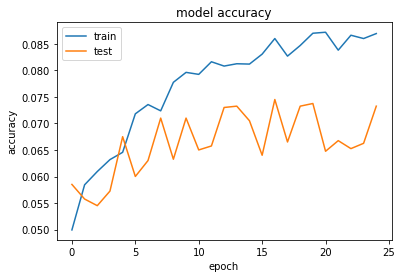

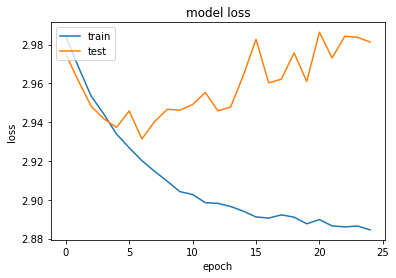

In [479]:
import matplotlib.pyplot as plt
%matplotlib inline
history = fit_results
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [480]:
scores = model.evaluate(x_val, y_val, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 9.28%


In [481]:
scores = model.evaluate(x_train, y_train, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 9.14%


In [438]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(15998, 1000)
(15998, 20)
(3999, 1000)
(3999, 20)


In [439]:
x_val.shape

(3999, 1000)

In [440]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_val)

In [441]:
print(testPredict.shape)
print(trainPredict.shape)

(3999, 20)
(15998, 20)


In [442]:
print(testPredict[2,].shape)
print(testPredict[2,])

(20,)
[  5.97854797e-03   7.98076780e-06   5.58154271e-13   2.01923900e-09
   1.58867537e-12   6.11546156e-08   5.20560484e-10   2.51164664e-07
   2.45673436e-06   1.78443482e-09   3.08538972e-10   4.94478045e-05
   4.70969042e-08   3.81403137e-04   2.67363768e-02   1.16167008e-03
   3.76769167e-04   4.61083346e-06   1.21752955e-02   9.53125179e-01]


In [443]:
print(trainPredict[1,].shape)
print(trainPredict[1,])

(20,)
[  1.46944086e-18   4.22768913e-08   4.51027826e-11   2.86849681e-05
   6.49054130e-07   1.32716433e-11   9.99930978e-01   5.13563747e-10
   3.83237741e-17   1.00604353e-18   2.31863072e-14   1.34394345e-15
   3.95656643e-05   3.26266818e-13   5.57568158e-10   2.22461094e-17
   2.99472225e-14   7.77286878e-16   6.83614677e-14   2.11238168e-18]


In [444]:
x_train[0,0:10000].shape

(1000,)

In [445]:
import numpy as np
tgt = x_train[1,0:10000]
print tgt.shape
tgt = tgt.reshape(1,1000)
print tgt.shape

(1000,)
(1, 1000)


In [446]:
tpr = model.predict(tgt)
print(tpr)

[[  1.46945203e-18   4.22769695e-08   4.51027826e-11   2.86850209e-05
    6.49057881e-07   1.32716685e-11   9.99930978e-01   5.13565745e-10
    3.83242141e-17   1.00605118e-18   2.31864851e-14   1.34393837e-15
    3.95658171e-05   3.26267442e-13   5.57568158e-10   2.22462814e-17
    2.99473953e-14   7.77280949e-16   6.83614677e-14   2.11238168e-18]]


In [447]:
print(np.round(tpr,2))

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]]


In [73]:
aa = []
aa.append("This is very stupid game.")


In [74]:
aa

['This is very stupid game.']

In [157]:
?mode.predict()

Object `mode.predict` not found.
